### Pregunta de Negocio - Analistes de Finances i Risc Crediticio

> ¿Qué **umbrales de saldo** podrían indicar mayor **riesgo de morosidad**?
>

### Carga de datos

In [1]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")#ignorar advertencias


#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

In [3]:
df = pd.read_csv("../Data/df_250519.csv")

### Analisis descriptivo de saldo segun default
comparar la distribucion de saldo entre los clientes que han tenido default y los que no.

```python

In [ ]:
promedio = df.groupby('default')['balance'].mean().round(2)
mediana = df.groupby('default')['balance'].median().round(2)
minimo = df.groupby('default')['balance'].min().round(2)
maximo = df.groupby('default')['balance'].max()
Descriptiva = pd.DataFrame({
    'Promedio': promedio,
    'Mediana': mediana,
    'Mínimo': minimo,
    'Máximo': maximo
})


print(Descriptiva)


         Promedio  Mediana  Mínimo  Máximo
default                                   
False     1537.25    563.0   -3058   81204
True       -78.89      0.0   -6847    5249


### Agupacion de saldos en rangos

Tasa global de incumplimiento: 0.0149
Tasa de incumplimiento por decil de saldo:
    balance_decile  default  indice_riesgo
0                1   0.0680           4.56
1                2   0.0323           2.17
2                3   0.0301           2.02
3                4   0.0177           1.19
4                5   0.0065           0.44
5                6   0.0111           0.74
6                7   0.0056           0.38
7                8   0.0009           0.06
8                9   0.0028           0.19
9               10   0.0047           0.32
10              11   0.0065           0.44
11              12   0.0000           0.00
12              13   0.0009           0.06
13              14   0.0000           0.00
14              15   0.0019           0.13


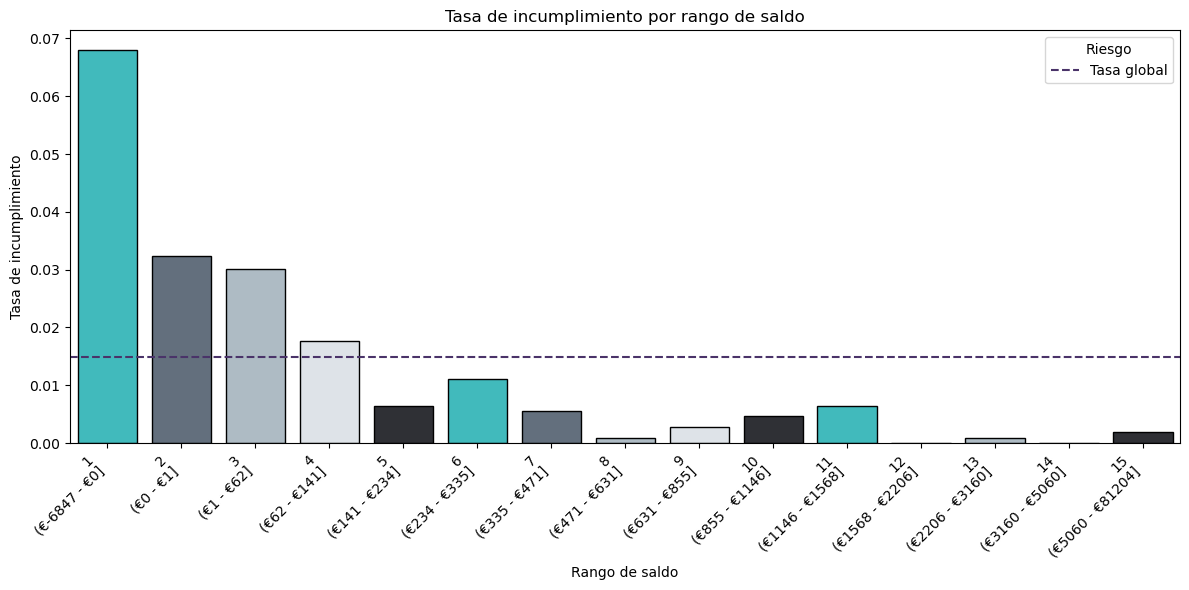

In [23]:
#  Crear rangos de balance para agrupar clientes en grupos iguales
df['balance_decile'] = pd.qcut(df['balance'], q=15, labels=False)

# Calcular la tasa de incumplimiento (default) por cada decil
default_rates = (df.groupby('balance_decile')['default'].mean().reset_index()) #la media aritmética en ese grupo equivale a la proporción (o tasa) de incumplimiento
default_rates['default'] = default_rates['default'].round(4) 
default_rates['balance_decile'] = default_rates['balance_decile'] + 1
Tasa_global_impagos = df['default'].mean()
print(f"Tasa global de incumplimiento: {Tasa_global_impagos:.4f}")
# Calculamos el indice de riesgo por decil riesgo/riesgo global
default_rates['indice_riesgo'] = default_rates['default'] / Tasa_global_impagos
default_rates['indice_riesgo'] = default_rates['indice_riesgo'].round(2)

#  Mostrar resultados en consola
print("Tasa de incumplimiento por decil de saldo:")
print(default_rates)

decile_labels = [
    f"{i+1}\n(€{int(interval.left)} - €{int(interval.right)}]"
    for i, interval in enumerate(balance_ranges)
]

#default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates, x='balance_decile', y='default', palette=custom_palette, edgecolor='black')
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(15), labels=decile_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por rango de saldo')
plt.xlabel('Rango de saldo')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Riesgo')
plt.tight_layout()
plt.show()



